## **Insurance Supervisory Analytics**

This notebook contains firm analysis of insurance data to help identify regulated firms that the team should focus on.

This notebook consists of the following parts:

1. Loading insurance data, then extracting and cleaning the data in order for the dataset to be analysed
2. Running analysis and metrics to determine the the firms that require the most attention, and visualising findings through a range of plots
3. Running K-means unsupervised machine learning algorithm to draw further insights from visualisations, and running evaluation plots

**Loading packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score

**Loading data**

In [5]:
path = "insurance_data.xlsx"
xls = pd.ExcelFile(path)

**Data cleaning and transformation**

In [6]:
# Function to clean and reshape data
def clean_data(df, type="long"):
    # Extract years and variables from the first two rows
    years = df.iloc[1].dropna().astype(str).str.extract(r'(\d+)')[0]
    variables = df.iloc[0].dropna().astype(str)

# Creating unique column names
    new_colnames = [f"{var}.{year}" for var, year in zip(variables, years)]

# Renaming and reshaping the dataframe
    df.columns = ['Firms'] + new_colnames
    tidy_df = df.drop(df.index[0:2])
    tidy_df = tidy_df.melt(id_vars=['Firms'], var_name='Variable_Year', value_name='value')
    
# Separating Variable and Year
    tidy_df[['Variable', 'Year']] = tidy_df['Variable_Year'].str.rsplit('.', n=1, expand=True)
    tidy_df.drop('Variable_Year', axis=1, inplace=True)
    
# Converting data types
    tidy_df['value'] = pd.to_numeric(tidy_df['value'], errors='coerce')
    tidy_df['Year'] = pd.to_datetime(tidy_df['Year'], format='%Y')

    if type == "wide":
        wide_df = tidy_df.pivot_table(index=['Firms', 'Year'], columns='Variable', values='value').reset_index()
        return wide_df

    return tidy_df

In [8]:
# Function to calculate changes and % change on a dataframe on all numeric columns
def calculate_changes(df):
    df_numeric = df.select_dtypes(include=['number'])
    for col in df_numeric.columns:
        df[f'{col} Change'] = df[col].diff()
        df[f'{col} % Change'] = df[col].pct_change()

    return df

In [9]:
# Read in all sheets
SupervisionMetrics = {sheet_name: xls.parse(sheet_name, header=None) for sheet_name in xls.sheet_names}

# Clean dataset to tidy data format
General_long = clean_data(SupervisionMetrics['Dataset 1 - General'], type="long")
Underwriting_long = clean_data(SupervisionMetrics['Dataset 2 - Underwriting'], type="long")

General_wide = clean_data(SupervisionMetrics['Dataset 1 - General'], type="wide")
Underwriting_wide = clean_data(SupervisionMetrics['Dataset 2 - Underwriting'], type="wide")

# Combine general and underwriting
combined_df_long = pd.concat([General_long, Underwriting_long])
combined_df_wide = pd.merge(General_wide, Underwriting_wide, on=["Firms", "Year"], how="outer")

# Supplementary tables
# Changes (nominal and percent)
General_changes = calculate_changes(General_wide)
Underwriting_changes = calculate_changes(Underwriting_wide)
combined_changes = calculate_changes(combined_df_wide)

# Condensed tables with main metrics
condensed_table = combined_df_wide.filter(regex="Firms|Year|GWP|NWP|SCR|Gross claims incurred|net combined")
condensed_table_changes = calculate_changes(condensed_table)

# Long format for charting
condensed_table_changes_long = condensed_table_changes.melt(id_vars=["Firms", "Year"], var_name="Metric")

C:\Users\329707\AppData\Local\Temp\ipykernel_29408\2090467526.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[f'{col} % Change'] = df[col].pct_change()
C:\Users\329707\AppData\Local\Temp\ipykernel_29408\2090467526.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[f'{col} % Change'] = df[col].pct_change()
C:\Users\329707\AppData\Local\Temp\ipykernel_29408\2090467526.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[f'{col} % Change'] = df[col].pct_change()
C:\Users\329707\AppDat

In [10]:
combined_df_long.head()

,Firms,value,Variable,Year
0,Firm 1,-17754.100486,NWP (£m),2016-01-01
1,Firm 2,9.244369,NWP (£m),2016-01-01
2,Firm 3,0.000000,NWP (£m),2016-01-01
3,Firm 4,19677.453353,NWP (£m),2016-01-01
4,Firm 5,128.812208,NWP (£m),2016-01-01


In [11]:
combined_df_wide.head()

Variable,Firms,Year,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),NWP (£m),SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m),...,"Net BEL (inc. TPs as a whole, pre-TMTP) (£m) Change","Net BEL (inc. TPs as a whole, pre-TMTP) (£m) % Change",Net combined ratio Change,Net combined ratio % Change,Net expense ratio Change,Net expense ratio % Change,Pure gross claims ratio Change,Pure gross claims ratio % Change,Pure net claims ratio Change,Pure net claims ratio % Change
0,Firm 1,2016-01-01,2416.559785,1243.924991,46.76803,-17754.100486,2.021322e+03,1.625197e-01,63676.869102,40171.683156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Firm 1,2017-01-01,3.796177,4.398725,0.00000,0.000000,6.940043e-09,5.588700e+07,9.566096,0.000000,...,9.894597,inf,71.298841,inf,41.01306,inf,17.534691,inf,17.184308,inf
2,Firm 1,2018-01-01,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,-9.894597,-1.0,-71.298841,-1.0,-41.01306,-1.0,-17.534691,-1.0,-17.184308,-1.0
3,Firm 1,2019-01-01,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
4,Firm 1,2020-01-01,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN


In [12]:
condensed_table_changes_long.head()

,Firms,Year,Metric,value
0,Firm 1,2016-01-01,EoF for SCR (£m),2416.559785
1,Firm 1,2017-01-01,EoF for SCR (£m),3.796177
2,Firm 1,2018-01-01,EoF for SCR (£m),0.000000
3,Firm 1,2019-01-01,EoF for SCR (£m),0.000000
4,Firm 1,2020-01-01,EoF for SCR (£m),0.000000


**Describing the data**

In [13]:
combined_df_wide.describe()

C:\Miniconda3\envs\sandbox\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Miniconda3\envs\sandbox\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Miniconda3\envs\sandbox\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Miniconda3\envs\sandbox\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Miniconda3\envs\sandbox\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Miniconda3\envs\sandbox\Lib\site-packages\numpy\core\_methods.py:49: Runt

Variable,Year,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),NWP (£m),SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",...,"Net BEL (inc. TPs as a whole, pre-TMTP) (£m) Change","Net BEL (inc. TPs as a whole, pre-TMTP) (£m) % Change",Net combined ratio Change,Net combined ratio % Change,Net expense ratio Change,Net expense ratio % Change,Pure gross claims ratio Change,Pure gross claims ratio % Change,Pure net claims ratio Change,Pure net claims ratio % Change
count,2280,1625.000000,1625.000000,1625.000000,1625.000000,1625.000000,1.625000e+03,1625.000000,1625.000000,2280.000000,...,2.279000e+03,1611.000000,2.279000e+03,1416.000000,2.279000e+03,1415.000000,2.279000e+03,1434.000000,2.279000e+03,1402.000000
mean,2017-12-31 19:11:59.999999744,504.096123,539.107196,936.694961,731.756135,346.635184,1.228704e+06,7244.856179,7080.304690,285.115521,...,-1.521478e-15,NaN,-2.089606e-13,NaN,1.817883e-13,NaN,1.108391e-14,NaN,-3.379725e-14,NaN
min,2016-01-01 00:00:00,-162.245016,-123.609578,-19.777480,-17754.100486,0.000000,-3.488211e+00,-207.356238,-1487.107764,-167.815824,...,-7.489545e+03,-inf,-5.468706e+06,-inf,-4.495420e+06,-inf,-9.850113e+05,-inf,-8.288094e+05,-inf
25%,2017-01-01 00:00:00,2.879599,3.515754,0.000000,0.000000,0.738866,2.914672e-01,6.543713,0.847367,0.000000,...,-5.564223e+00,-0.857189,-2.474251e-01,-0.833954,-8.750320e-02,-0.814629,-1.348911e-01,-0.813472,-1.379109e-01,-0.872374
50%,2018-01-01 00:00:00,25.548589,29.582864,8.686859,3.625627,11.637984,1.587490e+00,85.932872,45.545844,4.514229,...,0.000000e+00,-0.107897,0.000000e+00,-0.051726,0.000000e+00,-0.084421,0.000000e+00,-0.068265,0.000000e+00,-0.160472
75%,2019-01-01 00:00:00,162.428978,166.413248,178.699850,90.225184,91.415724,3.061232e+00,926.199445,643.826070,146.634626,...,7.800200e+00,2.563950,2.345166e-01,1.958989,9.149459e-02,1.831799,1.558628e-01,1.928986,1.064215e-01,2.121227
max,2020-01-01 00:00:00,41636.299252,26705.042053,74078.635849,75526.673293,22788.359468,9.993029e+08,553549.903858,494498.525611,19292.066525,...,1.121215e+04,inf,5.468706e+06,inf,4.495420e+06,inf,9.850113e+05,inf,8.288094e+05,inf
std,NaN,2262.296981,2174.167392,4757.190907,3969.009525,1570.005997,3.383049e+07,33462.818642,33527.811705,1007.437106,...,6.588776e+02,NaN,1.620599e+05,NaN,1.552462e+05,NaN,2.919615e+04,NaN,2.457847e+04,NaN


In [14]:
combined_df_wide.isnull().sum()

Variable
Firms                                                           0
Year                                                            0
EoF for SCR (£m)                                              655
Excess of assets over liabilities (£m) [= equity]             655
GWP (£m)                                                      655
NWP (£m)                                                      655
SCR (£m)                                                      655
SCR coverage ratio                                            655
Total assets (£m)                                             655
Total liabilities (£m)                                        655
Gross BEL (inc. TPs as whole, pre-TMTP) (£m)                    0
Gross claims incurred (£m)                                      0
Gross combined ratio                                            0
Gross expense ratio                                             0
Net BEL (inc. TPs as a whole, pre-TMTP) (£m)                    0
N

In [15]:
cleaned_data_wide = combined_df_wide.dropna()
cleaned_data_wide.head()

Variable,Firms,Year,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),NWP (£m),SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m),...,"Net BEL (inc. TPs as a whole, pre-TMTP) (£m) Change","Net BEL (inc. TPs as a whole, pre-TMTP) (£m) % Change",Net combined ratio Change,Net combined ratio % Change,Net expense ratio Change,Net expense ratio % Change,Pure gross claims ratio Change,Pure gross claims ratio % Change,Pure net claims ratio Change,Pure net claims ratio % Change
1,Firm 1,2017-01-01,3.796177,4.398725,0.000000,0.000000,6.940043e-09,5.588700e+07,9.566096,0.000000,...,9.894597,inf,71.298841,inf,41.013060,inf,17.534691,inf,17.184308,inf
5,Firm 10,2016-01-01,2052.581517,7807.061167,678.223770,404.116022,3.839042e+03,1.249246e+00,260340.852520,200126.398499,...,103.634752,inf,0.795576,inf,0.157259,inf,0.542120,inf,0.481683,inf
6,Firm 10,2017-01-01,11977.144969,8980.148360,9887.800616,3882.087306,5.102459e+03,6.691805e-01,156760.486097,130277.893116,...,-71.684087,-0.691699,0.350263,0.440263,0.666513,4.238318,1.070266,1.974223,-0.024567,-0.051003
7,Firm 10,2018-01-01,4128.905510,6395.468598,9002.108895,6640.433866,2.578827e+03,1.957921e+00,192068.205151,193831.906382,...,71.351266,2.233170,-0.652285,-0.569264,-0.404650,-0.491217,-0.411262,-0.255064,0.596656,1.305261
8,Firm 10,2019-01-01,5724.021346,4200.109278,10552.586690,5196.618355,3.234816e+02,1.112032e+00,205328.179783,91918.538245,...,-81.864062,-0.792474,1.016871,2.060302,-0.129028,-0.307854,-1.006293,-0.837793,-0.087624,-0.083153


**Exploratory analysis**

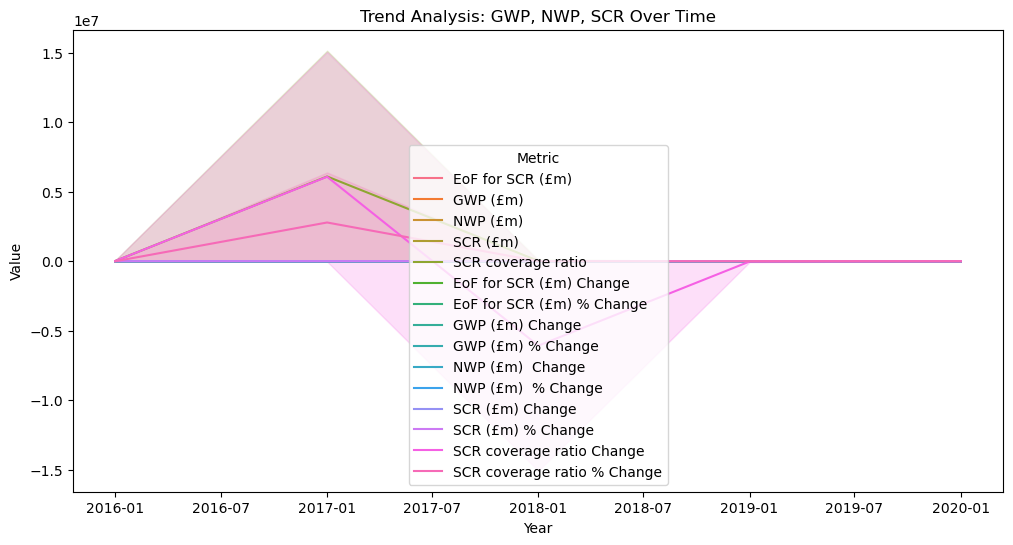

In [16]:
trend_metrics = combined_df_wide.filter(regex="Firms|Year|GWP|NWP|SCR")
trend_metrics_long = trend_metrics.melt(id_vars=["Firms", "Year"], var_name="Metric")

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_metrics_long, x="Year", y="value", hue="Metric")
plt.title('Trend Analysis: GWP, NWP, SCR Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.show()

From the trend analysis, we can see large changes in the data in 2017 and 2018 - indicating possible errors in the data which are causing large fluctuations

**Gross Written Premium (GWP) – total revenue written by an insurer. Equivalent of turnover for a non-insurance firm.**

In [17]:
#Here we will determine the top five firms with the highest GWP over the last 5 years
gwp_data = condensed_table_changes_long[condensed_table_changes_long['Metric'] == 'GWP (£m)']

latest_year = gwp_data['Year'].max()
last_five_years = [latest_year - pd.DateOffset(years=i) for i in range(5)]
gwp_last_5_years = gwp_data[gwp_data['Year'].isin(last_five_years)]

average_gwp_per_firm = gwp_last_5_years.groupby('Firms')['value'].mean()

top_firms_by_gwp = average_gwp_per_firm.sort_values(ascending=False)
top_firms_by_gwp

Firms
Firm 210    53157.315962
Firm 4      42837.104819
Firm 311    17110.301262
Firm 247    15542.935718
Firm 105    13330.761645
                ...     
Firm 452             NaN
Firm 453             NaN
Firm 454             NaN
Firm 455             NaN
Firm 456             NaN
Name: value, Length: 456, dtype: float64

Results show firm 210, firm 4, firm 311, firm 247 and firm 105 as reporting the highest GWP. Supervisors should also show concern to the five firms reporting negative GWP figures, these include firm 96, firm 56, firm 277, firm 207 and firm 61.

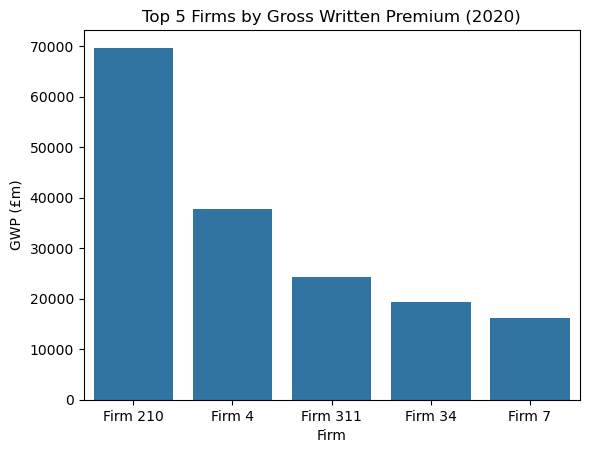

<Figure size 640x480 with 0 Axes>

In [18]:
#Chart showing top five firms with highest GWP in 2020
latest_year = condensed_table_changes_long['Year'].max()
latestTop5GWP = condensed_table_changes_long[
    (condensed_table_changes_long['Year'] == latest_year) &
    (condensed_table_changes_long['Metric'] == "GWP (£m)")
].nlargest(5, 'value')

sns.barplot(x='Firms', y='value', data=latestTop5GWP)
plt.title('Top 5 Firms by Gross Written Premium (2020)')
plt.xlabel('Firm')
plt.ylabel('GWP (£m)')
plt.show()
latestTop5GWP
plt.savefig('latestTop5GWP.png', bbox_inches='tight')

It is unusual to see firm 34 and firm 7 in the list, when on average over the last 5 years it has not appeared in the list as a firm with the highest GWP. This could possibly indicate firm 34 and firm 7 have reported an incorrect value. The trend for each of these firms will now be assessed:

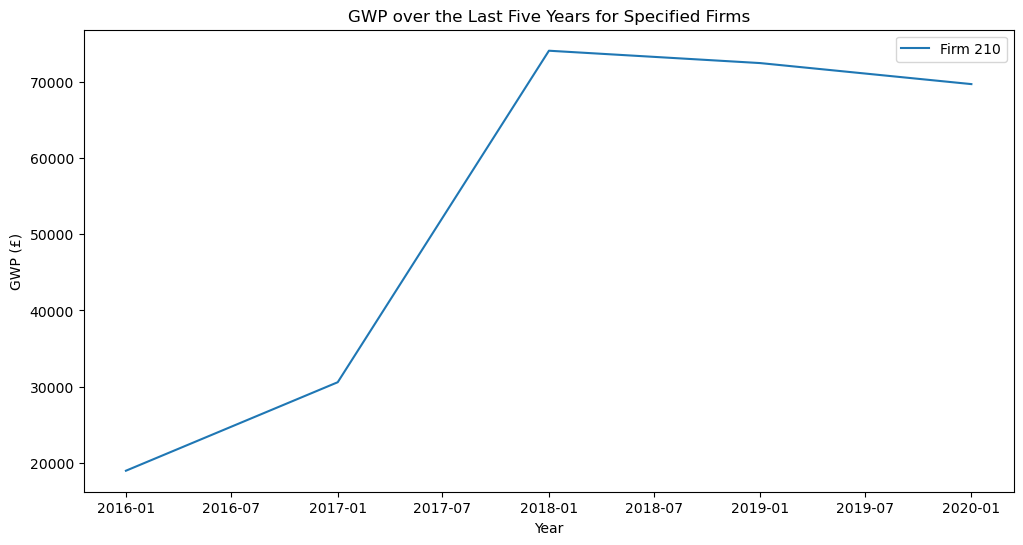

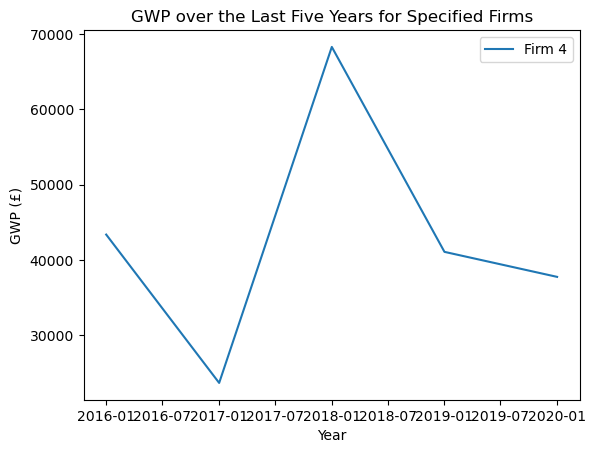

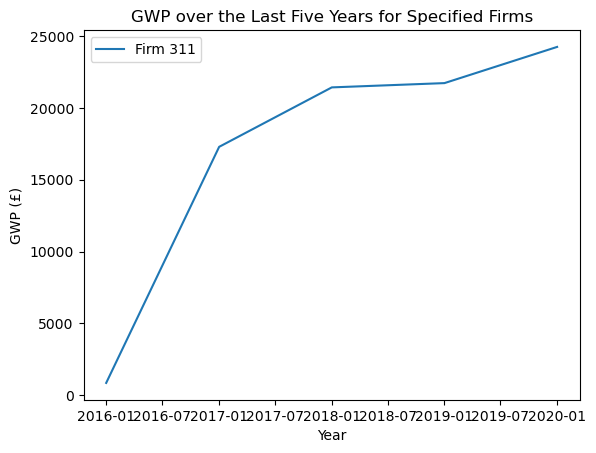

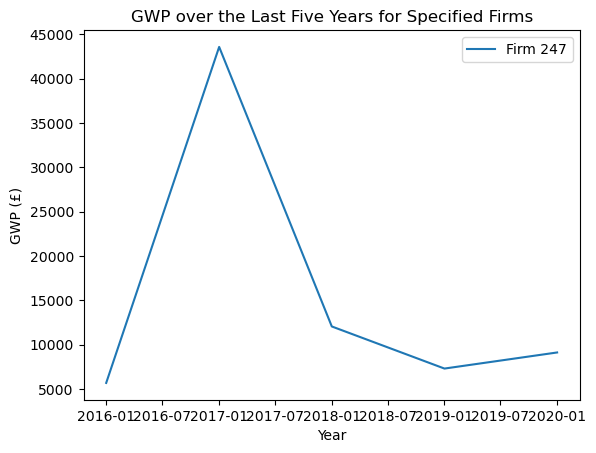

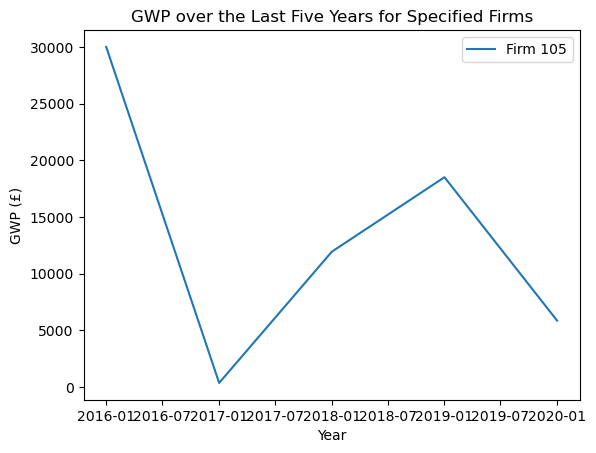

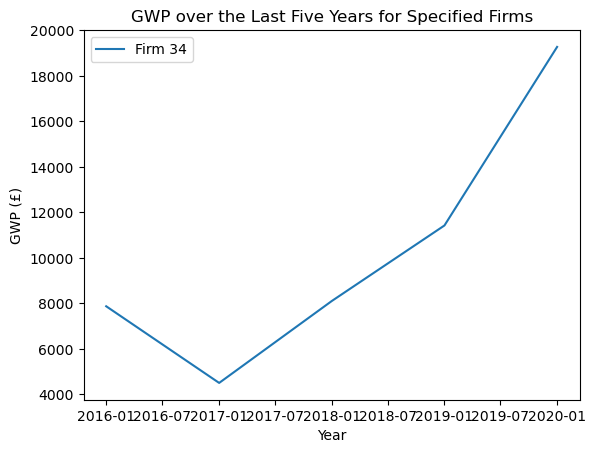

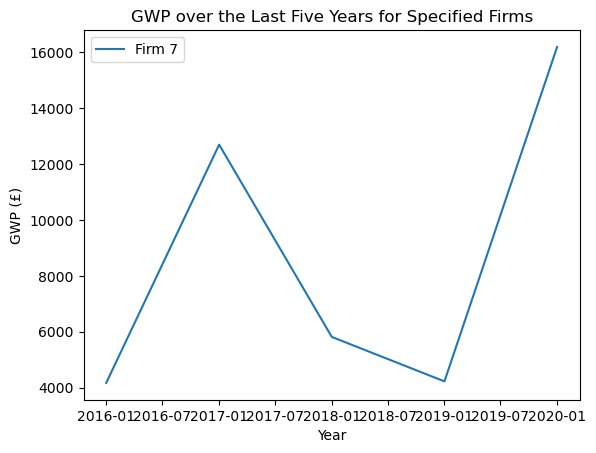

<Figure size 640x480 with 0 Axes>

In [19]:
specified_firms = ['Firm 210', 'Firm 4', 'Firm 311', 'Firm 247', 'Firm 105', 'Firm 34', 'Firm 7']
gwp_data = combined_df_long[
(combined_df_long['Firms'].isin(specified_firms)) &
(combined_df_long['Variable'] == 'GWP (£m)')
]

latest_year = gwp_data['Year'].max()
last_five_years = [latest_year - pd.offsets.DateOffset(years=i) for i in range(5)]
gwp_last_5_years = gwp_data[gwp_data['Year'].isin(last_five_years)]

plt.figure(figsize=(12, 6))
for firm in specified_firms:
    firm_data = gwp_last_5_years[gwp_last_5_years['Firms'] == firm]
    plt.plot(firm_data['Year'], firm_data['value'], label=firm)

    plt.title('GWP over the Last Five Years for Specified Firms')
    plt.xlabel('Year')
    plt.ylabel('GWP (£)')
    plt.legend()
    plt.show()
    latestTop5GWP
    plt.savefig('firmGWP5yrs', bbox_inches='tight')

Upon analysing the trends across specified firms, large fluctuations across firm 4, firm 247, firm 105 and firm 7 could indicate errors in their reporting or that there are serious financial issues the firm is facing as they are struggling to maintain a consistent GWP y-o-y.

**Net Written Premium (NWP) – GWP less reinsurance. NWP / GWP will show how much of the firm’s risk is being passed on to reinsurers.**

In [20]:
nwp_data = combined_df_long[combined_df_long['Variable'] == 'NWP (£m) ']

latest_year = nwp_data['Year'].max()
last_five_years = [latest_year - pd.DateOffset(years=i) for i in range(5)]
nwp_last_5_years = nwp_data[nwp_data['Year'].isin(last_five_years)]

average_nwp_per_firm = nwp_last_5_years.groupby('Firms')['value'].mean()

top_firms_by_nwp = average_nwp_per_firm.sort_values(ascending=False)
top_firms_by_nwp

Firms
Firm 210    35411.422650
Firm 4      29111.982801
Firm 26     22409.048775
Firm 105    16788.314194
Firm 311     8512.949759
                ...     
Firm 313      -27.236322
Firm 62       -38.127742
Firm 316      -73.785620
Firm 66      -364.958739
Firm 1      -3550.820097
Name: value, Length: 325, dtype: float64

Results show firm 210, firm 4, firm 26, firm 105 and firm 311 as reporting the highest NWP. Supervisors should also show concern to the five firms reporting negative NWP figures, these include firm 313, firm 62, firm 316, firm 66 and firm 1.

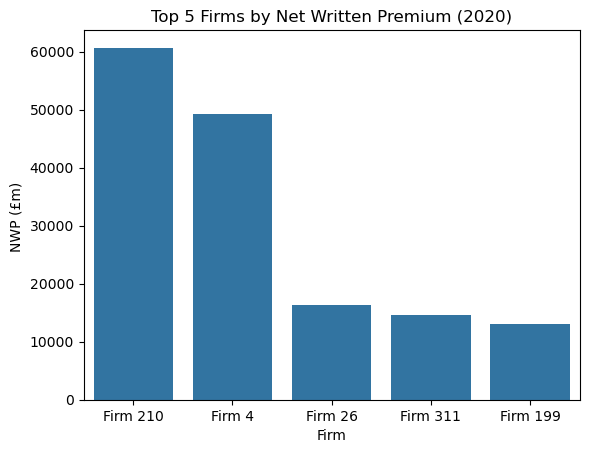

<Figure size 640x480 with 0 Axes>

In [21]:
#Chart showing top five firms with highest NWP in 2020
latest_year = condensed_table_changes_long['Year'].max()
latestTop5NWP = condensed_table_changes_long[
    (condensed_table_changes_long['Year'] == latest_year) &
    (condensed_table_changes_long['Metric'] == "NWP (£m) ")
].nlargest(5, 'value')

sns.barplot(x='Firms', y='value', data=latestTop5NWP)
plt.title('Top 5 Firms by Net Written Premium (2020)')
plt.xlabel('Firm')
plt.ylabel('NWP (£m) ')
plt.show()
plt.savefig('latestTop5NWP.png', bbox_inches='tight')

It is unusual to see firm 199 in the list, when on average over the last 5 years it has not appeared in the list as a firm with the highest NWP. This could possibly indicate firm 199 have reported an incorrect value. The trend for each of these firms will now be assessed:

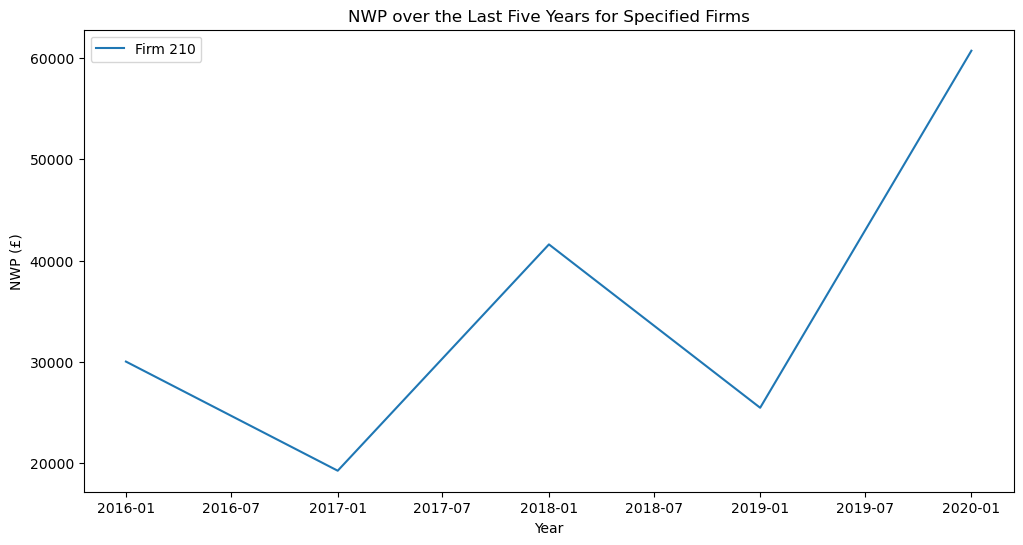

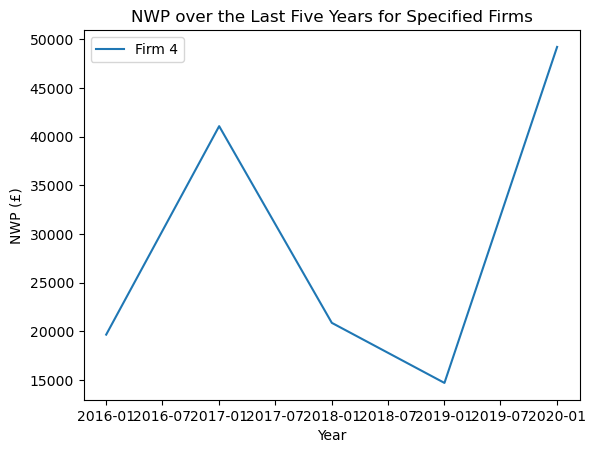

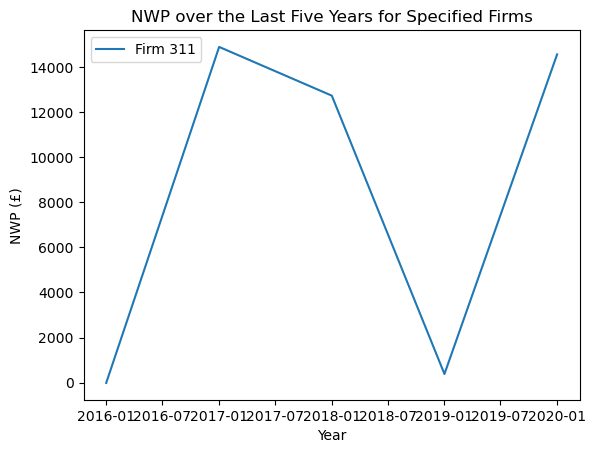

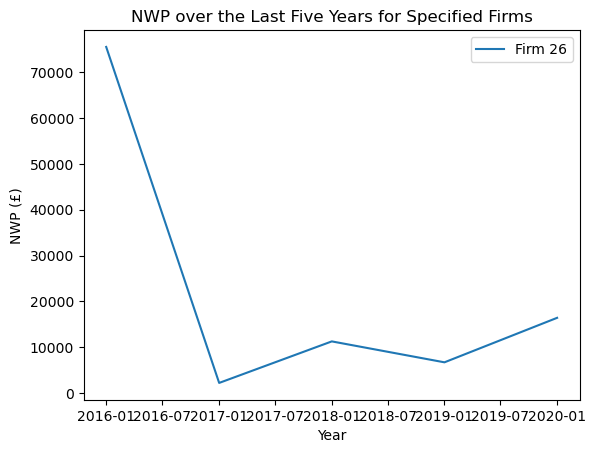

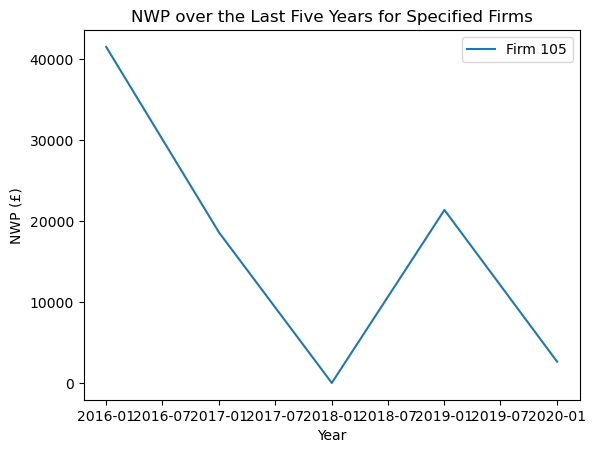

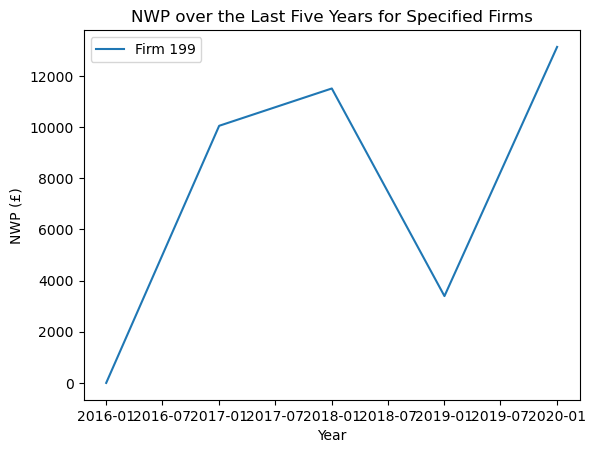

<Figure size 640x480 with 0 Axes>

In [22]:
specified_firms = ['Firm 210', 'Firm 4', 'Firm 311', 'Firm 26', 'Firm 105', 'Firm 199']
nwp_data = combined_df_long[
(combined_df_long['Firms'].isin(specified_firms)) &
(combined_df_long['Variable'] == 'NWP (£m) ')
]

latest_year = nwp_data['Year'].max()
last_five_years = [latest_year - pd.offsets.DateOffset(years=i) for i in range(5)]
nwp_last_5_years = nwp_data[nwp_data['Year'].isin(last_five_years)]

plt.figure(figsize=(12, 6))
for firm in specified_firms:
    firm_data = nwp_last_5_years[nwp_last_5_years['Firms'] == firm]
    plt.plot(firm_data['Year'], firm_data['value'], label=firm)

    plt.title('NWP over the Last Five Years for Specified Firms')
    plt.xlabel('Year')
    plt.ylabel('NWP (£)')
    plt.legend()
    plt.show()
    plt.savefig('firmNWP5yrs', bbox_inches='tight')

Upon analysing the trends across specified firms, large fluctuations across firm 4, firm 311, firm 199 firm 105 could indicate errors in their reporting or that there are serious financial issues the firm is facing as they are struggling to maintain a consistent NWP y-o-y.

**Gross claims incurred – a large cost to an insurer. Monitoring how these change over time for a firm is vital.**

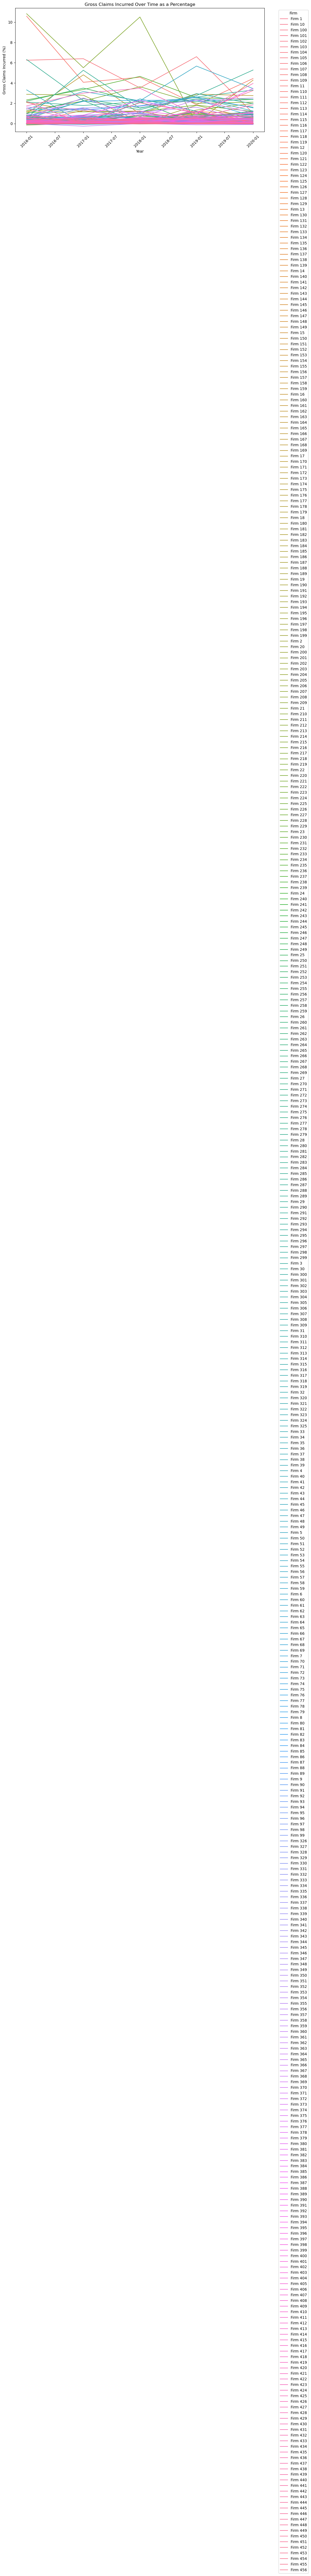

<Figure size 640x480 with 0 Axes>

In [23]:
gross_claims_data = combined_df_wide.filter(regex="Firms|Year|Gross claims incurred")

total_gross_claims_per_year = gross_claims_data.groupby('Year')['Gross claims incurred (£m)'].sum()

gross_claims_data = gross_claims_data.merge(total_gross_claims_per_year, on='Year', suffixes=('', '_total'))

gross_claims_data['Gross claims incurred %']= (gross_claims_data['Gross claims incurred (£m)'] / gross_claims_data['Gross claims incurred (£m)_total']) *100

plt.figure(figsize=(12, 6))
sns.lineplot(data=gross_claims_data, x="Year", y="Gross claims incurred %", hue="Firms")
plt.title('Gross Claims Incurred Over Time as a Percentage')
plt.xlabel('Year')
plt.ylabel('Gross Claims Incurred (%)')
plt.legend(title='Firm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()
plt.savefig('grossclaims', bbox_inches='tight')

In [24]:
average_gross_claims_per_firm = gross_claims_data.groupby('Firms')['Gross claims incurred (£m)'].mean()

top_5_firms_gross_claims = average_gross_claims_per_firm.nlargest(5)

top_5_firms_gross_claims

Firms
Firm 216    3319.574898
Firm 112    2947.025734
Firm 105    2818.049217
Firm 283    1991.336765
Firm 234    1848.847773
Name: Gross claims incurred (£m), dtype: float64

In [25]:
smallest_5_firms_gross_claims = average_gross_claims_per_firm.nsmallest(5)

smallest_5_firms_gross_claims

Firms
Firm 357   -38.234757
Firm 151   -25.728673
Firm 364   -23.710840
Firm 69    -14.213625
Firm 161   -13.440179
Name: Gross claims incurred (£m), dtype: float64

From the data we can see firm 216, firm 112, firm 105, firm 283 and firm 234 have the highest value for gross claims incurred over the last 5 years. This could indicate these firms have the largest cost to the insurer. 

**SCR coverage ratio – a measure of whether a firm is meeting its prudential capital requirements. Greater than 100% means the firm is holding enough capital to meet the requirement. The size of the buffer (i.e. surplus over 100%) can be important.** 

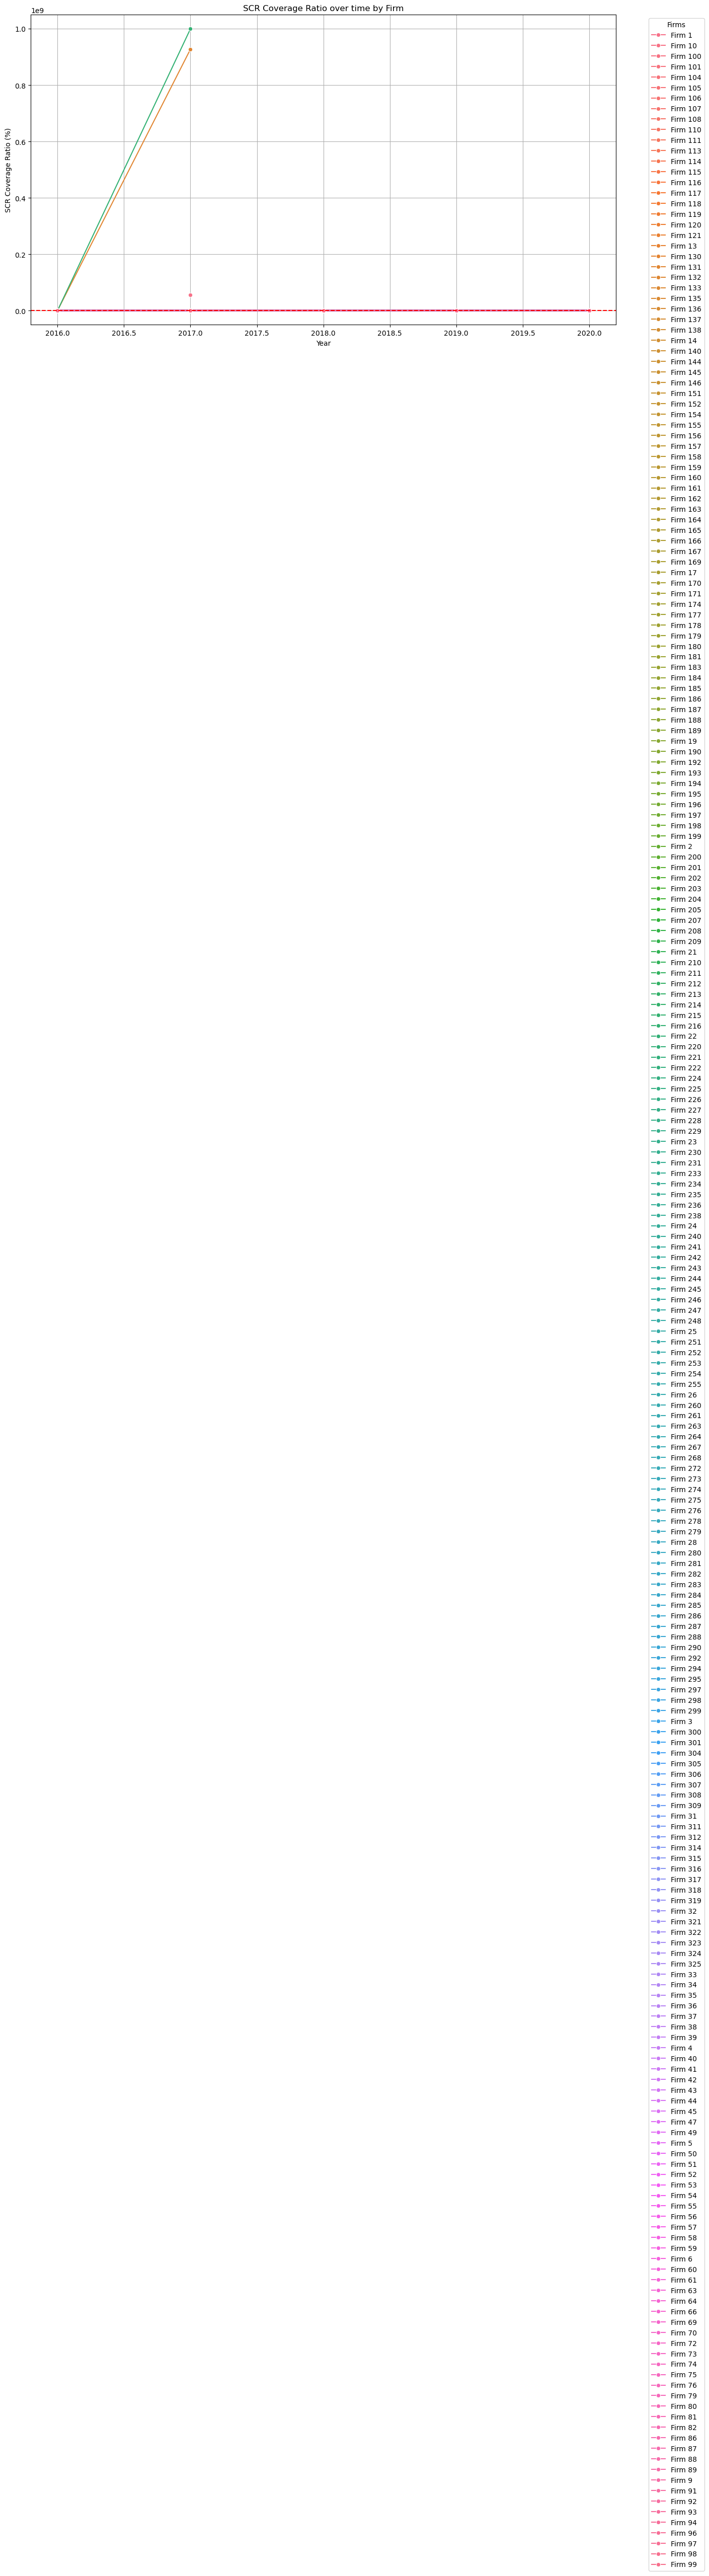

(0.4026845637583893, 660724313.8651091)

In [42]:
scr_data = combined_df_wide[['Firms', 'Year', 'SCR coverage ratio']].copy()
#scr_data['SCR Surplus/Deficit'] = scr_data['SCR coverage ratio'] - 100
scr_data.loc[:, 'SCR Surplus/Deficit'] = scr_data['SCR coverage ratio'] - 100

percentage_meeting_scr = (scr_data['SCR coverage ratio'] >= 100).mean() * 100

average_buffer = scr_data[scr_data['SCR coverage ratio'] > 100]['SCR Surplus/Deficit'].mean()

scr_data.loc[:, 'Year'] = pd.to_datetime(scr_data['Year']).dt.year
scr_data_grouped = scr_data.groupby(['Firms', 'Year'])['SCR coverage ratio'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(data=scr_data_grouped, x="Year", y="SCR coverage ratio", hue="Firms", marker='o')
plt.axhline(100, color='red', linestyle='--')
plt.title('SCR Coverage Ratio over time by Firm')
plt.xlabel('Year')
plt.ylabel('SCR Coverage Ratio (%)')
plt.legend(title='Firms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

percentage_meeting_scr, average_buffer

These figures represent the number of times these firms has an SCR coverage ratio below 100%, indicating they did not have enough capital to meet prudential requirements. The average SCR coverage ratio gives an indication of how far below the requirement they were on average during the observed periods.

In [46]:
firms_not_meeting_scr = scr_data[scr_data['SCR coverage ratio']< 100]

firms_not_meeting_scr_grouped = firms_not_meeting_scr.groupby('Firms').agg({'SCR coverage ratio': ['count', 'mean']}).reset_index()

firms_not_meeting_scr_grouped.columns = ['Firms', 'Count of Deficit Occurences', 'Average SCR Coverage Ratio']

firms_not_meeting_scr_grouped = firms_not_meeting_scr_grouped.sort_values(by='Count of Deficit Occurences', ascending=False)
firms_not_meeting_scr_grouped

,Firms,Count of Deficit Occurences,Average SCR Coverage Ratio
0,Firm 10,5,1.117433
116,Firm 243,5,3.401461
149,Firm 286,5,0.523751
146,Firm 283,5,3.271125
144,Firm 281,5,0.890077
...,...,...,...
24,Firm 135,1,1.035833
180,Firm 323,1,2.056229
25,Firm 136,1,3.933949
126,Firm 254,1,1.898272


We can conclude 240 firms have not met the SCR coverage ratio at least once over the past five years, with some firms having a deficit at least 5 times. 

**Outlier detection**

In [26]:
# Function to detect outliers in a dataframe
def outlier_detector(df):
    def outlier_column(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return (column < lower) | (column > upper)
    
    for col in df.select_dtypes(include=['number']).columns:
        df[f'Outlier_{col}'] = outlier_column(df[col])

    return df

In [27]:
outlier_table = outlier_detector(condensed_table)
outlier_rows = outlier_table[outlier_table.filter(like='Outlier').any(axis=1)]
outlier_rows.head()

C:\Users\329707\AppData\Local\Temp\ipykernel_29408\3824627520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Outlier_{col}'] = outlier_column(df[col])
C:\Users\329707\AppData\Local\Temp\ipykernel_29408\3824627520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Outlier_{col}'] = outlier_column(df[col])
C:\Users\329707\AppData\Local\Temp\ipykernel_29408\3824627520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Variable,Firms,Year,EoF for SCR (£m),GWP (£m),NWP (£m),SCR (£m),SCR coverage ratio,Gross claims incurred (£m),EoF for SCR (£m) Change,EoF for SCR (£m) % Change,...,Outlier_SCR (£m) % Change Change,Outlier_SCR (£m) % Change % Change,Outlier_SCR coverage ratio Change Change,Outlier_SCR coverage ratio Change % Change,Outlier_SCR coverage ratio % Change Change,Outlier_SCR coverage ratio % Change % Change,Outlier_Gross claims incurred (£m) Change Change,Outlier_Gross claims incurred (£m) Change % Change,Outlier_Gross claims incurred (£m) % Change Change,Outlier_Gross claims incurred (£m) % Change % Change
0,Firm 1,2016-01-01,2416.559785,46.76803,-17754.100486,2.021322e+03,1.625197e-01,0.000000,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,Firm 1,2017-01-01,3.796177,0.00000,0.000000,6.940043e-09,5.588700e+07,0.005515,-2412.763608,-0.998429,...,False,False,False,False,False,False,False,False,False,False
2,Firm 1,2018-01-01,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,-3.796177,-1.000000,...,False,False,True,False,True,False,False,False,True,False
3,Firm 1,2019-01-01,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,...,False,False,True,False,False,False,False,False,False,False
5,Firm 10,2016-01-01,2052.581517,678.22377,404.116022,3.839042e+03,1.249246e+00,3.671436,2052.581517,inf,...,False,True,False,True,False,True,False,True,False,True


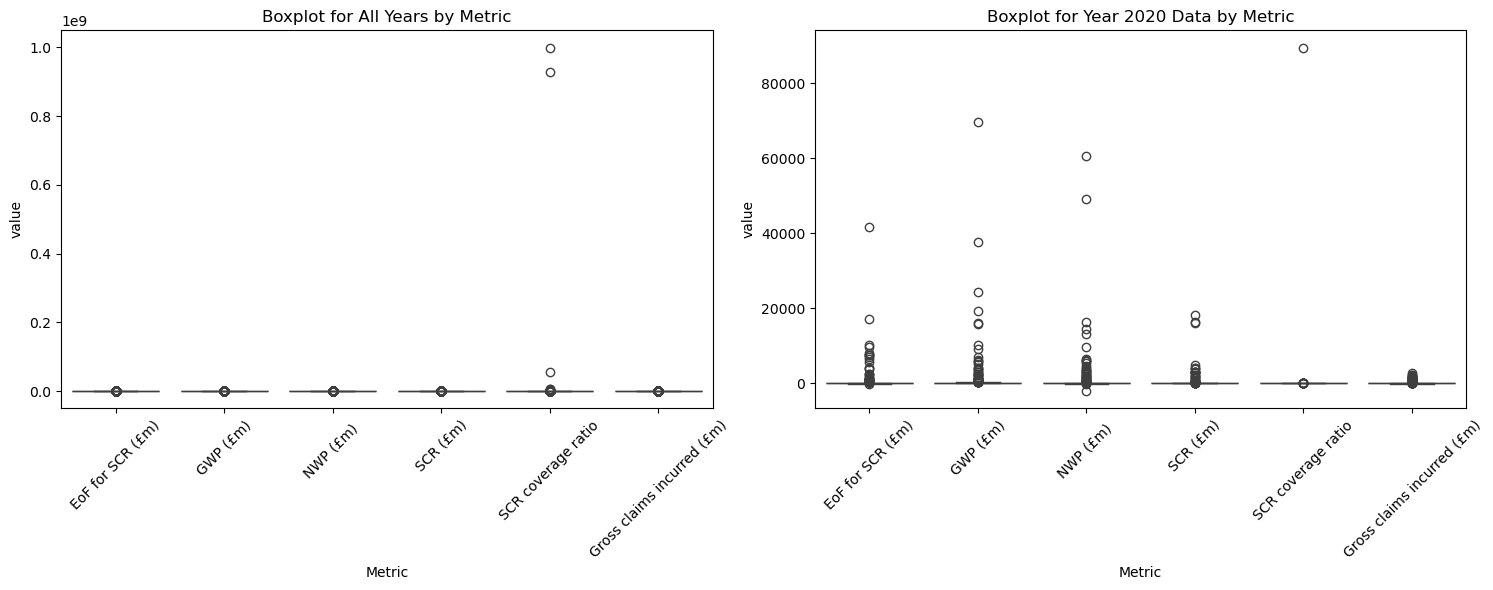

<Figure size 640x480 with 0 Axes>

In [28]:
data_for_boxplot = condensed_table_changes_long[~condensed_table_changes_long['Metric'].str.contains('Change', case=False)]

latest_year = data_for_boxplot['Year'].max()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Metric', y='value', data=data_for_boxplot)
plt.xticks(rotation=45)
plt.title('Boxplot for All Years by Metric')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x='Metric', y='value', data=data_for_boxplot[data_for_boxplot['Year'] == latest_year])
plt.xticks(rotation=45)
plt.title(f'Boxplot for Year {latest_year.year} Data by Metric')
plt.tight_layout()

plt.show()
plt.savefig('outlierboxplot', bbox_inches='tight')

C:\Users\329707\AppData\Local\Temp\ipykernel_29408\540170117.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\329707\AppData\Local\Temp\ipykernel_29408\540170117.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


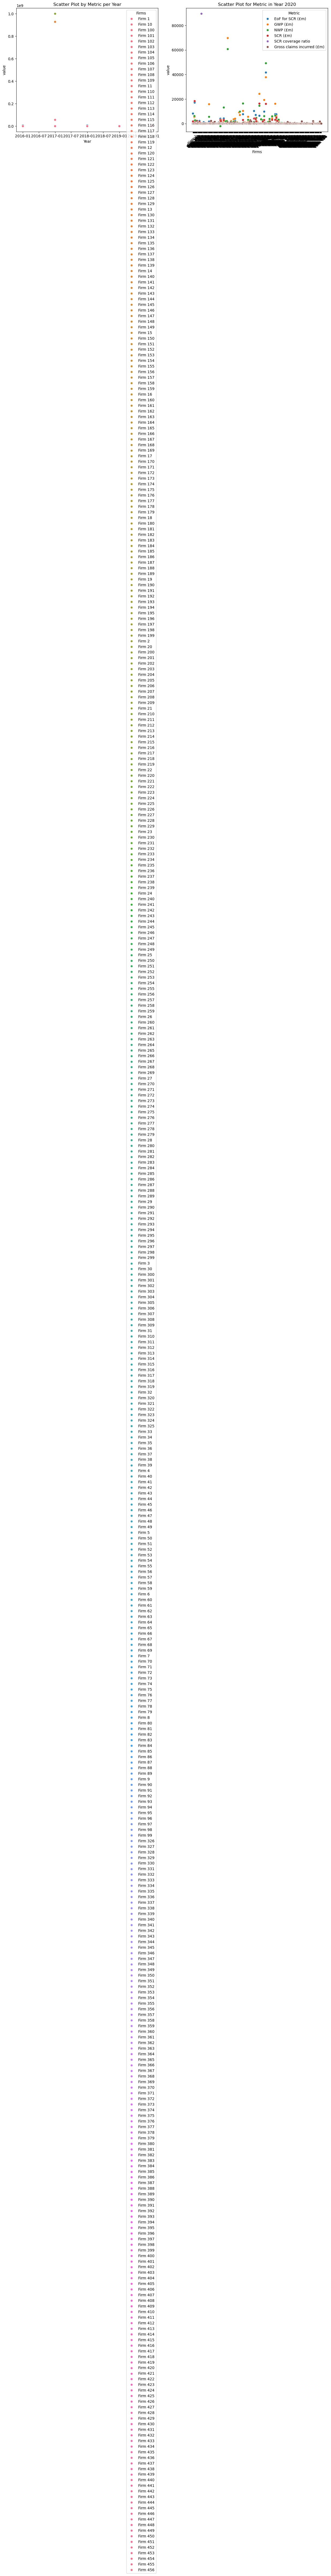

<Figure size 640x480 with 0 Axes>

In [29]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Year', y='value', hue='Firms', data=data_for_boxplot)
plt.title('Scatter Plot by Metric per Year')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.scatterplot(x='Firms', y='value', hue='Metric', data=data_for_boxplot[data_for_boxplot['Year'] == latest_year])
plt.xticks(rotation=45)
plt.title(f'Scatter Plot for Metric in Year {latest_year.year}')
plt.tight_layout()

plt.show()
plt.savefig('outlierscatter', bbox_inches='tight')

In [30]:
outlier_flags = outlier_table.filter(like='Outlier_')
outlier_counts = outlier_flags.groupby(outlier_table['Firms']).sum().sum(axis=1).sort_values(ascending=False)

top_20_firms_with_outliers = outlier_counts.head(20)
top_20_firms_with_outliers  

Firms
Firm 105    119
Firm 107    114
Firm 311    111
Firm 234    111
Firm 26     110
Firm 10     109
Firm 158    107
Firm 6      107
Firm 199    107
Firm 30     105
Firm 272    104
Firm 151    104
Firm 295    103
Firm 73     103
Firm 188    100
Firm 80     100
Firm 101     99
Firm 221     99
Firm 281     99
Firm 210     98
dtype: int64

**K-Means clustering**

K-means clustering is an example of unsupervised machine learning algorithm. The model can facilitate with understanding behavioural patterns across insurance metrics and is a helpful technique for supervisors to identify risk levels across insurance firms, based on Gross Written Premium (GWP) (£m), Net Written Premium (NWP) (£m), and Gross claims incurred (£m). The three clusters can be assigned initial centroids, which help reveal which points in the dataset are closest to each cluster. 

In [31]:
model = KMeans(n_clusters=3)

In [32]:
combined_df_wide=combined_df_wide.dropna()

In [33]:
X = combined_df_wide[['GWP (£m)', 'NWP (£m) ', 'Gross claims incurred (£m)']]
#y = costings['IBS']

In [34]:
model.fit(X)

C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=3)

C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


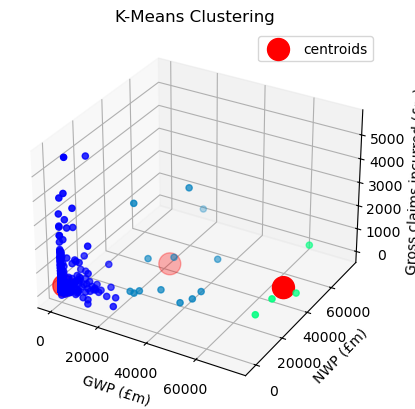

<Figure size 640x480 with 0 Axes>

In [35]:
km = KMeans(3)
clusts = km.fit_predict(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            km.cluster_centers_[:, 2],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
scatter = ax.scatter(combined_df_wide['GWP (£m)'], combined_df_wide['NWP (£m) '], combined_df_wide['Gross claims incurred (£m)'],
                     c=clusts,s=20, cmap='winter')


ax.set_title('K-Means Clustering')
ax.set_xlabel('GWP (£m)')
ax.set_ylabel('NWP (£m)')
ax.set_zlabel('Gross claims incurred (£m)')
ax.legend()
plt.show()
plt.savefig('kmeans', bbox_inches='tight')

The diagram shows clusters highlighted around three centroids highlighted in red. The clusters may depict the different risk groups such as low-risk, medium-risk and high-risk. This helps us understand that various risk levels exist across firms based on their GWP, NWP and gross claims, and the level of disruption they pose to financial stability. 

Silhouette analysis will be used to evaluate the K-Means clustering model. The silhouette scores will enable us to assess whether k values are significant, which will also identify whether outliers exist in the dataset and ensure clusters are assigned to the correct centroids.

C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Miniconda3\envs\sandbox\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when t

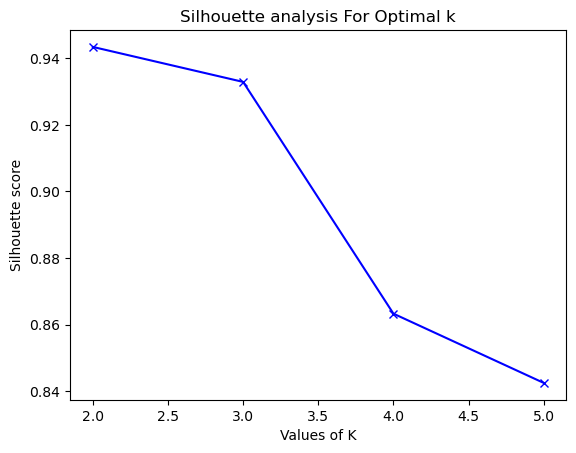

<Figure size 640x480 with 0 Axes>

In [36]:
range_n_clusters = [2, 3, 4, 5]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X)
  cluster_labels = kmeans.labels_

  silhouette_avg.append(silhouette_score(X, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()
plt.savefig('silhouette', bbox_inches='tight')

From the silhouette analysis, we can see that a K value of 2 produces the highest silhouette score which suggests the optimal number of clusters would be two. Anything greater than this value causes the silhouette score to diminish as we increase the K value.